In [25]:
%cd C:\\Users\\SahilSrivastava\\Desktop\\finalyear\

C:\Users\SahilSrivastava\Desktop\finalyear


C:\Users\SahilSrivastava\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import os
from glob import glob

excel_files = glob('./HourlyData/*.xlsx')

month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Sort the files based on the year and month extracted from the filenames
def extract_year_month(file_path):
    filename = os.path.basename(file_path)
    parts = filename.split('_')
    year = int(parts[2])
    month_name = parts[3]
    month = month_mapping[month_name]
    return year, month

excel_files = sorted(excel_files, key=extract_year_month)

# Initialize an empty DataFrame to store the combined data
all_data = pd.DataFrame()


# Loop through each file and read the data
# Loop through each file and read the data
for file in excel_files:
    # Read the Excel file, skipping rows and columns with NaN values
    df = pd.read_excel(file, header=0, index_col=0).dropna(axis=0, how='any').dropna(axis=1, how='any')
    # Extract year and month from the filename
    filename = os.path.basename(file)
    parts = filename.split('_')
    year = int(parts[2])
    month_name = parts[3]
    month = month_mapping[month_name]
    # Construct the datetime index using year, month, day, and hour information
    days_in_month = df.index
    hours_in_day = df.columns
    datetime_index = pd.date_range(start=f"{year}-{month:02d}-01 00:00:00", 
                                   periods=len(days_in_month)*len(hours_in_day), freq='h')
    # Reshape the data to have a datetime index and AQI values
    reshaped_data = pd.DataFrame(df.values.flatten(), index=datetime_index, columns=['AQI'])
    # Append to the combined DataFrame
    all_data = pd.concat([all_data, reshaped_data])


# Sort by datetime index
all_data = all_data.sort_index()

# Handle missing values
all_data = all_data.ffill().bfill()

# Display the first few rows of the processed data
print(all_data)

                       AQI
2020-01-01 00:00:00  500.0
2020-01-01 01:00:00  500.0
2020-01-01 02:00:00  500.0
2020-01-01 03:00:00  500.0
2020-01-01 04:00:00  494.0
...                    ...
2023-12-26 19:00:00  155.0
2023-12-26 20:00:00  208.0
2023-12-26 21:00:00  278.0
2023-12-26 22:00:00  312.0
2023-12-26 23:00:00  314.0

[25848 rows x 1 columns]


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Extract features and target from the data
X = all_data.index.values  # Time as the feature
y = all_data['AQI'].values  # AQI as the target

# Convert the datetime index to ordinal values (numeric) for modeling
X = pd.to_datetime(all_data.index).to_series().apply(lambda x: x.toordinal()).values.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, shuffle=False)

# Print shapes to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (25589, 1), y_train shape: (25589,)
X_test shape: (259, 1), y_test shape: (259,)


In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

# Check for NaN values in X_train and y_train
nan_indices = np.isnan(X_train).any(axis=1) | np.isnan(y_train)

# Remove rows with NaN values
X_train_cleaned = X_train[~nan_indices]
y_train_cleaned = y_train[~nan_indices]

# Define and initialize the Linear Regression model
lr_model = LinearRegression()

# Fit the model
lr_model.fit(X_train_cleaned, y_train_cleaned)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Calculate evaluation metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

# Print the evaluation metrics
print(f"Linear Regression MSE: {mse_lr}, R2: {r2_lr},MAE:{mae_lr}")


Linear Regression MSE: 15115.637783254264, R2: -1.3363680920334615,MAE:108.55741329874556


In [5]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_lr = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf}, R2: {r2_rf},MAE:{mae_lr}")


Random Forest MSE: 13941.730411001467, R2: -1.1549215816802736,MAE:104.43909909909908


In [6]:
import xgboost as xgb

# XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_lr = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb}, R2: {r2_xgb},MAE:{mae_lr}")


XGBoost MSE: 7013.709385599107, R2: -0.08408305691627094,MAE:72.4378409956413


In [7]:
from sklearn.svm import SVR

# Support Vector Machine model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_svr = svr_model.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
mae_lr = mean_absolute_error(y_test, y_pred_svr)
print(f"SVM MSE: {mse_svr}, R2: {r2_svr},MAE:{mae_lr}")


SVM MSE: 21300.84414556383, R2: -2.292392508254374,MAE:129.125569145197


In [8]:
from sklearn.neighbors import KNeighborsRegressor

# K-Nearest Neighbors model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn_model.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
mae_lr = mean_absolute_error(y_test, y_pred_knn)

print(f"KNN MSE: {mse_knn}, R2: {r2_knn},,MAE: {mae_lr}")


KNN MSE: 14294.245405405407, R2: -1.2094085174416707,,MAE: 105.67644787644787


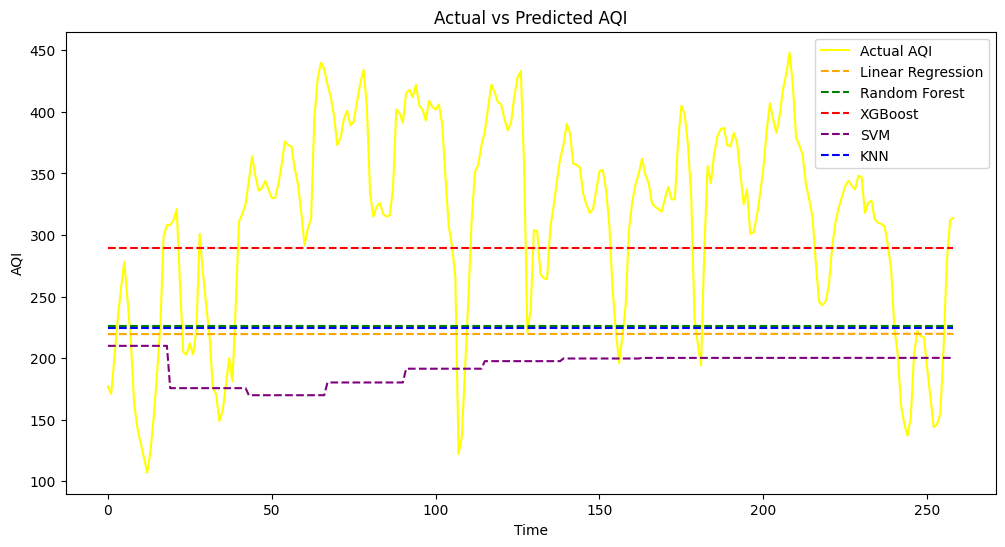

In [9]:
import matplotlib.pyplot as plt

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual AQI', linestyle='-', color='yellow')
plt.plot(y_pred_lr, label='Linear Regression', linestyle='--', color='orange')
plt.plot(y_pred_rf, label='Random Forest', linestyle='--', color='green')
plt.plot(y_pred_xgb, label='XGBoost', linestyle='--', color='red')
plt.plot(y_pred_svr, label='SVM', linestyle='--', color='purple')
plt.plot(y_pred_knn, label='KNN', linestyle='--', color='blue')
plt.legend()
plt.xlabel('Time')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI')
plt.show()


                       AQI  hour  day_of_week  day_of_month  month  AQI_lag1
2020-01-01 06:00:00  492.0     6            2             1      1     500.0
2020-01-01 07:00:00  477.0     7            2             1      1     492.0
2020-01-01 08:00:00  500.0     8            2             1      1     477.0
2020-01-01 09:00:00  476.0     9            2             1      1     500.0
2020-01-01 10:00:00  466.0    10            2             1      1     476.0
...                    ...   ...          ...           ...    ...       ...
2023-12-26 19:00:00  155.0    19            1            26     12     146.0
2023-12-26 20:00:00  208.0    20            1            26     12     155.0
2023-12-26 21:00:00  278.0    21            1            26     12     208.0
2023-12-26 22:00:00  312.0    22            1            26     12     278.0
2023-12-26 23:00:00  314.0    23            1            26     12     312.0

[25842 rows x 6 columns]
Linear Regression MSE: 1288.1051629472283, R2: 0.9

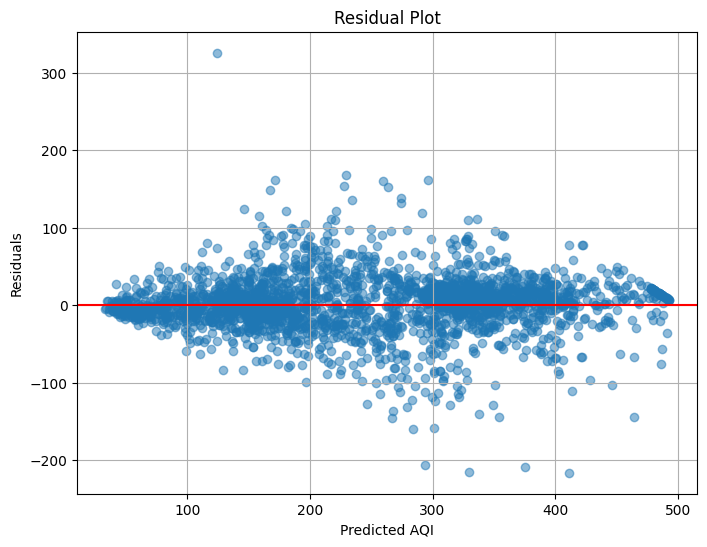

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Extract additional temporal features
all_data['hour'] = all_data.index.hour
all_data['day_of_week'] = all_data.index.dayofweek
all_data['day_of_month'] = all_data.index.day
all_data['month'] = all_data.index.month

# Optionally, you could also create lag features (e.g., previous hour's AQI)
all_data['AQI_lag1'] = all_data['AQI'].shift(1)
all_data = all_data.dropna()  # Drop rows with NaN values resulting from lagging
print(all_data)
# Define the features (X) and the target (y)
X = all_data[['hour', 'day_of_week', 'day_of_month', 'month', 'AQI_lag1']]
y = all_data['AQI']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Calculate evaluation metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

# Print the evaluation metrics
print(f"Linear Regression MSE: {mse_lr}, R2: {r2_lr}, MAE: {mae_lr}")

# Visualize Residuals
import matplotlib.pyplot as plt

residuals = y_test - y_pred_lr
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lr, residuals, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted AQI')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.show()


In [4]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf}, R2: {r2_rf}, MAE: {mae_rf}")


Random Forest MSE: 1202.9682717988396, R2: 0.9149047997914231, MAE: 23.44001547388781


In [17]:
import xgboost as xgb

# Train an XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb}, R2: {r2_xgb}, MAE: {mae_xgb}")


XGBoost MSE: 1161.5524639995408, R2: 0.9178344584857554, MAE: 23.083849688885984


In [6]:
from sklearn.svm import SVR

# Train a Support Vector Regressor
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_svr = svr_model.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)

print(f"SVR MSE: {mse_svr}, R2: {r2_svr}, MAE: {mae_svr}")


SVR MSE: 3285.6771410155243, R2: 0.7675787793493738, MAE: 41.48007553076037


In [7]:
from sklearn.neighbors import KNeighborsRegressor

# Train a K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn_model.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

print(f"KNN MSE: {mse_knn}, R2: {r2_knn}, MAE: {mae_knn}")


KNN MSE: 1365.5837988394585, R2: 0.9034017525748472, MAE: 25.2084332688588


In [8]:
from sklearn.neural_network import MLPRegressor

# Train a Neural Network Regressor
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_mlp = mlp_model.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)

print(f"Neural Network MSE: {mse_mlp}, R2: {r2_mlp}, MAE: {mae_mlp}")


Neural Network MSE: 1206.1511038652375, R2: 0.9146796535940797, MAE: 23.348118387970334


In [20]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50,100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.1,0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.1,0.6, 0.7, 0.8, 0.9, 1.0]
}


# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_best_xgb = best_xgb_model.predict(X_test)
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)

print(f"Optimized XGBoost MSE: {mse_best_xgb}, R2: {r2_best_xgb}, MAE: {mae_best_xgb}")


Fitting 3 folds for each of 2880 candidates, totalling 8640 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
Optimized XGBoost MSE: 998.9406201193567, R2: 0.9293372451640594, MAE: 21.157948514248464


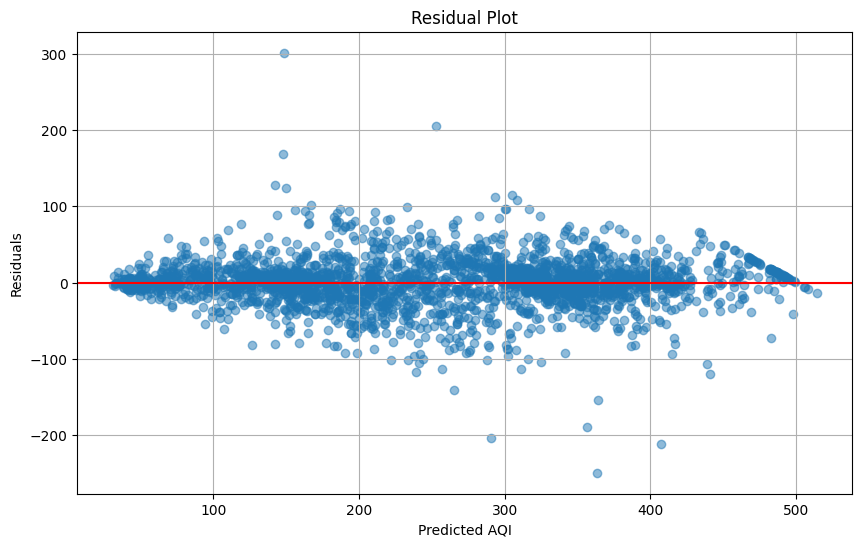

In [21]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred_best_xgb

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best_xgb, residuals, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted AQI')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.show()


In [22]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define the refined parameter grid for Grid Search
param_grid = {
    'n_estimators': [250, 300, 350],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42), 
                           param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_best_xgb = best_xgb_model.predict(X_test)
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)

print(f"Optimized XGBoost MSE: {mse_best_xgb}, R2: {r2_best_xgb}, MAE: {mae_best_xgb}")


Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 350, 'reg_alpha': 0.5, 'reg_lambda': 1.5, 'subsample': 0.9}
Optimized XGBoost MSE: 998.3278457871194, R2: 0.9293805914066052, MAE: 21.102750381233612


In [29]:
import pandas as pd
from glob import glob
import os

# Define the folder path and get the list of Excel files
folder_path = './HourlyData'
excel_files = glob(os.path.join(folder_path, '*.xlsx'))

# Mapping month names to numbers
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Function to extract year and month from the filename
def extract_year_month(file_path):
    filename = os.path.basename(file_path)
    parts = filename.split('_')
    year = int(parts[2])
    month_name = parts[3]
    month = month_mapping[month_name]
    return year, month

# Sort the files based on the year and month extracted from the filenames
excel_files = sorted(excel_files, key=extract_year_month)

# Initialize an empty DataFrame to store the combined data
all_data = pd.DataFrame()

# Loop through each file and read the data
for file in excel_files:
    df = pd.read_excel(file, header=0, index_col=0)
    year, month = extract_year_month(file)
    days_in_month = df.index
    hours_in_day = df.columns
    datetime_index = pd.date_range(start=f"{year}-{month:02d}-01 00:00:00", 
                                   periods=len(days_in_month)*len(hours_in_day), freq='h')
    reshaped_data = pd.DataFrame(df.values.flatten(), index=datetime_index, columns=['AQI'])
    all_data = pd.concat([all_data, reshaped_data])

all_data = all_data.sort_index()

# Add temporal features
all_data['day_of_week'] = all_data.index.dayofweek
all_data['hour'] = all_data.index.hour
all_data['day'] = all_data.index.day
all_data['month'] = all_data.index.month

# Create lag features
for lag in range(1, 25):
    all_data[f'lag_{lag}'] = all_data['AQI'].shift(lag)

# Create rolling statistics features
all_data['rolling_mean_24'] = all_data['AQI'].rolling(window=24).mean()
all_data['rolling_std_24'] = all_data['AQI'].rolling(window=24).std()

# Drop rows with NaN values
all_data = all_data.dropna()

# Store the data into an Excel file
all_data.to_excel('enhanced_aqi_data.xlsx')

# Display the first few rows of the processed data
print(all_data.head())


                       AQI  day_of_week  hour  day  month  lag_1  lag_2  \
2020-01-02 00:00:00  498.0            3     0    2      1  482.0  433.0   
2020-01-02 01:00:00  500.0            3     1    2      1  498.0  482.0   
2020-01-02 02:00:00  500.0            3     2    2      1  500.0  498.0   
2020-01-02 03:00:00  483.0            3     3    2      1  500.0  500.0   
2020-01-02 04:00:00  494.0            3     4    2      1  483.0  500.0   

                     lag_3  lag_4  lag_5  ...  lag_17  lag_18  lag_19  lag_20  \
2020-01-02 00:00:00  407.0  358.0  247.0  ...   477.0   492.0   500.0   494.0   
2020-01-02 01:00:00  433.0  407.0  358.0  ...   500.0   477.0   492.0   500.0   
2020-01-02 02:00:00  482.0  433.0  407.0  ...   476.0   500.0   477.0   492.0   
2020-01-02 03:00:00  498.0  482.0  433.0  ...   466.0   476.0   500.0   477.0   
2020-01-02 04:00:00  500.0  498.0  482.0  ...   416.0   466.0   476.0   500.0   

                     lag_21  lag_22  lag_23  lag_24  rolling_m

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from bayes_opt import BayesianOptimization

# Load the enhanced data
all_data = pd.read_excel('enhanced_aqi_data.xlsx', index_col=0, parse_dates=True)

# Extract features and target from the data
X = all_data.drop(columns=['AQI']).values
y = all_data['AQI'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Define the function to optimize
def xgb_evaluate(max_depth, gamma, colsample_bytree, min_child_weight, subsample):
    params = {
        'max_depth': int(max_depth),
        'gamma': gamma,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': int(min_child_weight),
        'subsample': subsample,
        'learning_rate': 0.03,
        'n_estimators': 350,
        'reg_alpha': 0.5,
        'reg_lambda': 1.5
    }
    model = xgb.XGBRegressor(**params, objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -mean_squared_error(y_test, y_pred)

# Set up the optimizer
xgb_bo = BayesianOptimization(
    f=xgb_evaluate,
    pbounds={
        'max_depth': (3, 10),
        'gamma': (0, 1),
        'colsample_bytree': (0.3, 1.0),
        'min_child_weight': (1, 10),
        'subsample': (0.6, 1.0)
    },
    random_state=42
)

# Perform optimization
xgb_bo.maximize(init_points=10, n_iter=50)

# Extract the best parameters
best_params = xgb_bo.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

# Train the final model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params, learning_rate=0.03, n_estimators=350, reg_alpha=0.5, reg_lambda=1.5, objective='reg:squarederror', random_state=42)
best_xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_best_xgb = best_xgb_model.predict(X_test)
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)

print(f"Optimized XGBoost MSE: {mse_best_xgb}, R2: {r2_best_xgb}, MAE: {mae_best_xgb}")


|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
| 1         | -916.6    | 0.5622    | 0.9507    | 8.124     | 6.388     | 0.6624    |
| 2         | -953.5    | 0.4092    | 0.05808   | 9.063     | 6.41      | 0.8832    |
| 3         | -1.029e+0 | 0.3144    | 0.9699    | 8.827     | 2.911     | 0.6727    |
| 4         | -933.8    | 0.4284    | 0.3042    | 6.673     | 4.888     | 0.7165    |
| 5         | -895.8    | 0.7283    | 0.1395    | 5.045     | 4.297     | 0.7824    |
| 6         | -889.8    | 0.8496    | 0.1997    | 6.6       | 6.332     | 0.6186    |
| 7         | -949.7    | 0.7253    | 0.1705    | 3.455     | 9.54      | 0.9863    |
| 8         | -945.3    | 0.8659    | 0.3046    | 3.684     | 7.158     | 0.7761    |
| 9         | -1.062e+0 | 0.3854    | 0.4952    | 3.241     | 9.184     | 0.7035    |
| 10        | -886.4    | 0.7638    | 0.3117    | 6.64

In [53]:
import pandas as pd
import numpy as np
import datetime as dt

# Define the datetime you want to predict for
predict_datetime = pd.to_datetime('2020-05-15 15:00:00')

# Prepare the feature data for this datetime
features = {}

# Extract temporal features
features['day_of_week'] = predict_datetime.dayofweek
features['hour'] = predict_datetime.hour
features['day'] = predict_datetime.day
features['month'] = predict_datetime.month

# Extract lag features and rolling statistics
# This requires having the historical data up to the prediction datetime
lag_hours = 24  # Assuming lag features up to 24 hours
historical_data = all_data[all_data.index <= predict_datetime].tail(lag_hours + 1)

# Create lag features
for lag in range(1, lag_hours + 1):
    features[f'lag_{lag}'] = historical_data['AQI'].shift(lag).values[-1]

# Create rolling statistics features
features['rolling_mean_24'] = historical_data['AQI'].rolling(window=24).mean().values[-1]
features['rolling_std_24'] = historical_data['AQI'].rolling(window=24).std().values[-1]

# Convert to DataFrame
features_df = pd.DataFrame([features])

# Handle missing values if any (e.g., for the first few hours of data)
features_df.fillna(0, inplace=True)  # Or use a more sophisticated method


In [32]:
import xgboost as xgb
import joblib

# Load the trained model (replace 'xgboost_model.pkl' with your model file path)
best_xgb_model = joblib.load('best_xgboost_model.pkl')

# Predict AQI for the given datetime
predicted_aqi = best_xgb_model.predict(features_df)

print(f"Predicted AQI for {predict_datetime}: {predicted_aqi[0]}")


FileNotFoundError: [Errno 2] No such file or directory: 'best_xgboost_model.pkl'

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from bayes_opt import BayesianOptimization
import joblib

# Load the enhanced data
all_data = pd.read_excel('enhanced_aqi_data.xlsx', index_col=0, parse_dates=True)

# Extract features and target from the data
X = all_data.drop(columns=['AQI']).values
y = all_data['AQI'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Define the function to optimize
def xgb_evaluate(max_depth, gamma, colsample_bytree, min_child_weight, subsample):
    params = {
        'max_depth': int(max_depth),
        'gamma': gamma,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': int(min_child_weight),
        'subsample': subsample,
        'learning_rate': 0.03,
        'n_estimators': 350,
        'reg_alpha': 0.5,
        'reg_lambda': 1.5
    }
    model = xgb.XGBRegressor(**params, objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -mean_squared_error(y_test, y_pred)

# Set up the optimizer
xgb_bo = BayesianOptimization(
    f=xgb_evaluate,
    pbounds={
        'max_depth': (3, 10),
        'gamma': (0, 1),
        'colsample_bytree': (0.3, 1.0),
        'min_child_weight': (1, 10),
        'subsample': (0.6, 1.0)
    },
    random_state=42
)

# Perform optimization
xgb_bo.maximize(init_points=10, n_iter=50)

# Extract the best parameters
best_params = xgb_bo.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

# Train the final model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params, learning_rate=0.03, n_estimators=350, reg_alpha=0.5, reg_lambda=1.5, objective='reg:squarederror', random_state=42)
best_xgb_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(best_xgb_model, 'best_xgboost_model.pkl')

# Predict and evaluate
y_pred_best_xgb = best_xgb_model.predict(X_test)
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)

print(f"Optimized XGBoost MSE: {mse_best_xgb}, R2: {r2_best_xgb}, MAE: {mae_best_xgb}")


|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
| 1         | -916.6    | 0.5622    | 0.9507    | 8.124     | 6.388     | 0.6624    |
| 2         | -953.5    | 0.4092    | 0.05808   | 9.063     | 6.41      | 0.8832    |
| 3         | -1.029e+0 | 0.3144    | 0.9699    | 8.827     | 2.911     | 0.6727    |
| 4         | -933.8    | 0.4284    | 0.3042    | 6.673     | 4.888     | 0.7165    |
| 5         | -895.8    | 0.7283    | 0.1395    | 5.045     | 4.297     | 0.7824    |
| 6         | -889.8    | 0.8496    | 0.1997    | 6.6       | 6.332     | 0.6186    |
| 7         | -949.7    | 0.7253    | 0.1705    | 3.455     | 9.54      | 0.9863    |
| 8         | -945.3    | 0.8659    | 0.3046    | 3.684     | 7.158     | 0.7761    |
| 9         | -1.062e+0 | 0.3854    | 0.4952    | 3.241     | 9.184     | 0.7035    |
| 10        | -886.4    | 0.7638    | 0.3117    | 6.64

In [42]:
import pandas as pd
import numpy as np
import datetime as dt
import joblib

# Define the datetime you want to predict for
predict_datetime = pd.to_datetime('2023-12-29 17:00:00')

# Load the enhanced data
all_data = pd.read_excel('enhanced_aqi_data.xlsx', index_col=0, parse_dates=True)

# Prepare the feature data for this datetime
features = {}

# Extract temporal features
features['day_of_week'] = predict_datetime.dayofweek
features['hour'] = predict_datetime.hour
features['day'] = predict_datetime.day
features['month'] = predict_datetime.month

# Extract lag features and rolling statistics
lag_hours = 24  # Assuming lag features up to 24 hours
historical_data = all_data[all_data.index <= predict_datetime].tail(lag_hours + 1)

# Create lag features
for lag in range(1, lag_hours + 1):
    features[f'lag_{lag}'] = historical_data['AQI'].shift(lag).values[-1]

# Create rolling statistics features
features['rolling_mean_24'] = historical_data['AQI'].rolling(window=24).mean().values[-1]
features['rolling_std_24'] = historical_data['AQI'].rolling(window=24).std().values[-1]

# Convert to DataFrame
features_df = pd.DataFrame([features])

# Handle missing values if any (e.g., for the first few hours of data)
features_df.fillna(0, inplace=True)  # Or use a more sophisticated method

# Load the trained model
best_xgb_model = joblib.load('best_xgboost_model.pkl')

# Predict AQI for the given datetime
predicted_aqi = best_xgb_model.predict(features_df)

print(f"Predicted AQI for {predict_datetime}: {predicted_aqi[0]}")


Predicted AQI for 2023-12-29 17:00:00: 162.53492736816406


In [48]:
import pandas as pd
import os
from glob import glob

# Load monthly rainfall data
monthly_rainfall_file = 'monthly_rainfall_data.xlsx'
monthly_rainfall = pd.read_excel(monthly_rainfall_file)
monthly_rainfall['Month-Year'] = pd.to_datetime(monthly_rainfall['Month-Year'], format='%b-%y')
monthly_rainfall.set_index('Month-Year', inplace=True)
print(monthly_rainfall.head())

# Path to the folder containing daily AQI data files
daily_aqi_folder = './DailyData'
daily_aqi_files = glob(os.path.join(daily_aqi_folder, '*.xlsx'))

# Initialize an empty DataFrame to hold the combined daily AQI data
daily_aqi_combined = pd.DataFrame()

# Month mapping to convert month names to numbers
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Loop through each file and read the data
for file in daily_aqi_files:
    filename = os.path.basename(file)
    year = filename.split('_')[2]
    df = pd.read_excel(file, index_col=0)
    df = df.reset_index().melt(id_vars=['index'], var_name='Month', value_name='AQI')
    df.rename(columns={'index': 'Day'}, inplace=True)
    df['Month'] = df['Month'].map(month_mapping)
    df['Year'] = year
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1), errors='coerce')
    daily_aqi_combined = pd.concat([daily_aqi_combined, df])

daily_aqi_combined.set_index('Date', inplace=True)
daily_aqi_combined.sort_index(inplace=True)
daily_aqi_combined.drop(columns=['Year', 'Month', 'Day'], inplace=True)
print(daily_aqi_combined.head())

# Merge daily AQI data with monthly rainfall data
daily_aqi_combined.reset_index(inplace=True)
daily_aqi_combined['Month-Year'] = daily_aqi_combined['Date'].dt.to_period('M')
daily_aqi_combined['Month-Year'] = daily_aqi_combined['Month-Year'].dt.to_timestamp()

combined_data = pd.merge(daily_aqi_combined, monthly_rainfall, how='left', left_on='Month-Year', right_index=True)
combined_data.drop(columns=['Month-Year'], inplace=True)
combined_data.set_index('Date', inplace=True)

# Save the combined data to a new Excel file
combined_data.to_excel('combined_aqi_rainfall_data.xlsx')
print(combined_data.head())


KeyError: 'Month-Year'

In [46]:
%pwd


'C:\\Users\\SahilSrivastava\\Desktop\\finalyear'

In [69]:
import pandas as pd

# Path to the monthly rainfall data file
monthly_rainfall_file = 'monthly_rainfall_data.xlsx'

# Load the monthly rainfall data
rainfall_data = pd.read_excel(monthly_rainfall_file, header=None, names=['Month-Year', 'Rainfall_mm'])

# Convert 'MonthYear' to datetime format
rainfall_data['Month-Year'] = pd.to_datetime(rainfall_data['Month-Year'], format='%b-%y')

# Set 'MonthYear' as the index
rainfall_data.set_index('Month-Year', inplace=True)

# Display the first few rows to verify
print(rainfall_data.head())

# Save the processed monthly rainfall data to a new Excel file (optional)
rainfall_data.to_excel('processed_monthly_rainfall_data.xlsx')


            Rainfall_mm
Month-Year             
2020-01-01        13.48
2020-02-01         0.96
2020-03-01        42.08
2020-04-01         5.76
2020-05-01        16.69


In [61]:
import pandas as pd
import os
from glob import glob

# Path to the folder containing daily AQI data files
daily_aqi_folder = './DailyData'

# List all Excel files in the folder
daily_aqi_files = glob(os.path.join(daily_aqi_folder, '*.xlsx'))

# Initialize an empty DataFrame to hold the combined daily AQI data
daily_aqi_combined = pd.DataFrame()

# Month mapping to convert month names to numbers
month_mapping = {
    'January': '01', 'February': '02', 'March': '03', 'April': '04',
    'May': '05', 'June': '06', 'July': '07', 'August': '08',
    'September': '09', 'October': '10', 'November': '11', 'December': '12'
}

# Loop through each file and read the data
for file in daily_aqi_files:
    # Extract year from the filename
    filename = os.path.basename(file)
    year = filename.split('_')[2]
    
    # Read the Excel file, assuming the first row contains month names and the first column contains dates
    df = pd.read_excel(file, header=0, index_col=0)
    
    # Rename the index to 'Day' for clarity
    df.index.name = 'Day'
    
    # Print the dataframe to debug
    print(f"DataFrame from file {file}:\n", df.head())
    
    # Melt the DataFrame to long format
    df = df.reset_index().melt(id_vars=['Day'], var_name='Month', value_name='AQI')
    
    # Print the melted dataframe to debug
    print(f"Melted DataFrame from file {file}:\n", df.head())
    
    # Map month names to numbers
    df['Month'] = df['Month'].map(month_mapping)
    
    # Create a date column
    df['Date'] = pd.to_datetime(year + '-' + df['Month'] + '-' + df['Day'].astype(str), format='%Y-%m-%d', errors='coerce')
    
    # Print the dataframe with date to debug
    print(f"DataFrame with Date column from file {file}:\n", df.head())
    
    # Remove rows where 'Date' is NaT (not a time)
    df = df.dropna(subset=['Date'])
    
    # Append to the combined DataFrame
    daily_aqi_combined = pd.concat([daily_aqi_combined, df])

# Print the combined dataframe before setting index to debug
print("Combined DataFrame before setting index:\n", daily_aqi_combined.head())

# Set the date as the index and sort
daily_aqi_combined.set_index('Date', inplace=True)
daily_aqi_combined.sort_index(inplace=True)

# Drop intermediate columns
daily_aqi_combined.drop(columns=['Month', 'Day'], inplace=True)

# Save the combined daily AQI data to a new Excel file
daily_aqi_combined.to_excel('combined_daily_aqi_data.xlsx')

# Display the first few rows to verify
print(daily_aqi_combined.head())


DataFrame from file ./DailyData\AQI_daily_2020_Knowledge_Park_III_Greater_Noida_UPPCB_2020.xlsx:
      January  February  March  April    May   June  July  August  September  \
Day                                                                           
1      417.0     266.0   54.0  112.0    NaN  115.0   103    47.0       57.0   
2      378.0     243.0  144.0  111.0  106.0  102.0   124   153.0       62.0   
3      307.0     274.0  229.0  113.0   96.0  168.0   140    90.0       73.0   
4      323.0       NaN  208.0  115.0   76.0  137.0    93    92.0       69.0   
5      350.0       NaN   71.0  109.0  103.0   85.0    51    90.0       62.0   

     October  November  December  
Day                               
1        155     356.0     374.0  
2        174     306.0     399.0  
3        192     313.0     358.0  
4        198     331.0       NaN  
5        171     457.0     401.0  
Melted DataFrame from file ./DailyData\AQI_daily_2020_Knowledge_Park_III_Greater_Noida_UPPCB_2020.xlsx:

In [63]:
# Load the combined daily AQI data
daily_aqi_combined = pd.read_excel('combined_daily_aqi_data.xlsx', index_col='Date', parse_dates=True)

# Aggregate daily AQI to monthly AQI
monthly_aqi = daily_aqi_combined.resample('ME').mean()

# Display the first few rows to verify
print(monthly_aqi.head())


                   AQI
Date                  
2020-01-31  294.640000
2020-02-29  236.730769
2020-03-31  141.608696
2020-04-30  120.172414
2020-05-31  126.640000


In [76]:
import pandas as pd

# Load the rainfall data
rainfall_data = pd.read_excel('processed_monthly_rainfall_data.xlsx', header=None, names=['Month-Year', 'Rainfall'])

# Print the first few rows to inspect the date format
print(rainfall_data.head())


            Month-Year     Rainfall
0           Month-Year  Rainfall_mm
1  2020-01-01 00:00:00        13.48
2  2020-02-01 00:00:00         0.96
3  2020-03-01 00:00:00        42.08
4  2020-04-01 00:00:00         5.76


In [78]:
import pandas as pd
from dateutil import parser

# Load the rainfall data, skipping the first row which contains headers
rainfall_data = pd.read_excel('processed_monthly_rainfall_data.xlsx', header=1, names=['Month-Year', 'Rainfall'])

# Convert 'Month-Year' to datetime format for proper merging
rainfall_data['Date'] = pd.to_datetime(rainfall_data['Month-Year'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Set the 'Date' column as the index
rainfall_data.set_index('Date', inplace=True)

# Drop the original 'Month-Year' column as it's no longer needed
rainfall_data.drop(columns=['Month-Year'], inplace=True)

# Print the processed rainfall data to verify
print("Processed Rainfall Data:\n", rainfall_data.head())


Processed Rainfall Data:
             Rainfall
Date                
2020-02-01      0.96
2020-03-01     42.08
2020-04-01      5.76
2020-05-01     16.69
2020-06-01      8.70


In [84]:
# Load the monthly mean AQI data
monthly_aqi_mean = pd.read_excel('combined_daily_aqi_data.xlsx', index_col='Date')

# Print the monthly mean AQI data to verify
print("Monthly Mean AQI Data:\n", monthly_aqi_mean.head())

# Merge the monthly mean AQI data with the rainfall data
combined_data = monthly_aqi_mean.merge(rainfall_data, left_index=True, right_index=True, how='inner')
# Ensure no NaN values in the combined dataset
combined_data.dropna(inplace=True)

# Print the combined data to verify
print("Combined Data:\n", combined_data.head())

# Save the combined data to an Excel file for future reference
combined_data.to_excel('combined_aqi_rainfall_data.xlsx')


Monthly Mean AQI Data:
               AQI
Date             
2020-01-01  417.0
2020-01-02  378.0
2020-01-03  307.0
2020-01-04  323.0
2020-01-05  350.0
Combined Data:
               AQI  Rainfall
Date                       
2020-02-01  266.0      0.96
2020-03-01   54.0     42.08
2020-04-01  112.0      5.76
2020-06-01  115.0      8.70
2020-07-01  103.0     21.66


In [86]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import joblib

# Define features and target
X = combined_data[['Rainfall']]
y = combined_data['AQI']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the existing XGBoost model (assuming it was saved previously)
xgboost_model = joblib.load('best_xgboost_model.pkl')

# Re-train the model with the new combined data
xgboost_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgboost_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Re-trained XGBoost with Rainfall MSE: {mse}, R2: {r2}, MAE: {mae}")

# Save the re-trained model to a file for future use
joblib.dump(xgboost_model, 'retrained_xgboost_model_with_rainfall.pkl')

# Function to predict AQI for a specific date and rainfall
def predict_aqi(date, rainfall):
    model = joblib.load('retrained_xgboost_model_with_rainfall.pkl')
    date = pd.to_datetime(date)
    X_new = pd.DataFrame({'Rainfall': [rainfall]}, index=[date])
    return model.predict(X_new)

# Example usage
date = '2021-05-15'
rainfall = 50  # example rainfall value in mm
predicted_aqi = predict_aqi(date, rainfall)
print(f"Predicted AQI for {date} with {rainfall} mm rainfall: {predicted_aqi[0]}")


Re-trained XGBoost with Rainfall MSE: 15935.57711957038, R2: -0.13360189283385004, MAE: 111.27733866373698
Predicted AQI for 2021-05-15 with 50 mm rainfall: 205.21408081054688


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import joblib



# Define features and target
X = combined_data[['Rainfall']]
y = combined_data['AQI']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the existing XGBoost model (assuming it was saved previously)
xgboost_model = joblib.load('best_xgboost_model.pkl')

# Re-train the model with the new combined data
xgboost_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgboost_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Re-trained XGBoost with Rainfall MSE: {mse}, R2: {r2}, MAE: {mae}")

# Save the re-trained model to a file for future use
joblib.dump(xgboost_model, 'retrained_xgboost_model_with_rainfall.pkl')

# Function to predict AQI for a specific date and rainfall
def predict_aqi(date, rainfall):
    model = joblib.load('retrained_xgboost_model_with_rainfall.pkl')
    date = pd.to_datetime(date)
    X_new = pd.DataFrame({'Rainfall': [rainfall]}, index=[date])
    return model.predict(X_new)

# Example usage
date = '2021-05-15'
rainfall = 50  # example rainfall value in mm
predicted_aqi = predict_aqi(date, rainfall)
print(f"Predicted AQI for {date} with {rainfall} mm rainfall: {predicted_aqi[0]}")


Re-trained XGBoost with Rainfall MSE: 15935.57711957038, R2: -0.13360189283385004, MAE: 111.27733866373698
Predicted AQI for 2021-05-15 with 50 mm rainfall: 205.21408081054688


In [87]:
import pandas as pd

# Load the previously saved combined data
combined_data = pd.read_excel('combined_aqi_rainfall_data.xlsx', index_col=0)

# Drop rows with NaN values to ensure clean data
combined_data.dropna(inplace=True)

# Verify the combined data
print(combined_data.head())


              AQI  Rainfall
Date                       
2020-02-01  266.0      0.96
2020-03-01   54.0     42.08
2020-04-01  112.0      5.76
2020-06-01  115.0      8.70
2020-07-01  103.0     21.66


In [88]:
# Extract month and season from the date index
combined_data['Month'] = combined_data.index.month
combined_data['Season'] = combined_data['Month'] % 12 // 3 + 1

# Verify the additional features
print(combined_data.head())


              AQI  Rainfall  Month  Season
Date                                      
2020-02-01  266.0      0.96      2       1
2020-03-01   54.0     42.08      3       2
2020-04-01  112.0      5.76      4       2
2020-06-01  115.0      8.70      6       3
2020-07-01  103.0     21.66      7       3


In [89]:
from sklearn.model_selection import train_test_split

# Define features and target
features = ['Rainfall', 'Month', 'Season']
X = combined_data[features]
y = combined_data['AQI']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (24, 3), y_train shape: (24,)
X_test shape: (6, 3), y_test shape: (6,)


In [91]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

# Define the XGBoost model
xgboost_model = xgb.XGBRegressor()

# Fit the model
xgboost_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgboost_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Re-trained XGBoost with Additional Features MSE: {mse}, R2: {r2}, MAE: {mae}")

# Save the re-trained model to a file for future use
joblib.dump(xgboost_model, 'retrained_xgboost_model_with_additional_features.pkl')


Re-trained XGBoost with Additional Features MSE: 19706.287597174185, R2: -0.4018372069782392, MAE: 113.95569483439128


['retrained_xgboost_model_with_additional_features.pkl']

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from bayes_opt import BayesianOptimization
import joblib

# Load the enhanced data
all_data = pd.read_excel('enhanced_aqi_data.xlsx', index_col=0, parse_dates=True)

# Extract features and target from the data
X = all_data.drop(columns=['AQI']).values
y = all_data['AQI'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Define the function to optimize
def xgb_evaluate(max_depth, gamma, colsample_bytree, min_child_weight, subsample):
    params = {
        'max_depth': int(max_depth),
        'gamma': gamma,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': int(min_child_weight),
        'subsample': subsample,
        'learning_rate': 0.03,
        'n_estimators': 350,
        'reg_alpha': 0.5,
        'reg_lambda': 1.5
    }
    model = xgb.XGBRegressor(**params, objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -mean_squared_error(y_test, y_pred)

# Set up the optimizer
xgb_bo = BayesianOptimization(
    f=xgb_evaluate,
    pbounds={
        'max_depth': (3, 10),
        'gamma': (0, 1),
        'colsample_bytree': (0.3, 1.0),
        'min_child_weight': (1, 10),
        'subsample': (0.6, 1.0)
    },
    random_state=42
)

# Perform optimization
xgb_bo.maximize(init_points=10, n_iter=50)

# Extract the best parameters
best_params = xgb_bo.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

# Train the final model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params, learning_rate=0.03, n_estimators=350, reg_alpha=0.5, reg_lambda=1.5, objective='reg:squarederror', random_state=42)
best_xgb_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(best_xgb_model, 'best_xgboost_model.pkl')

# Predict and evaluate
y_pred_best_xgb = best_xgb_model.predict(X_test)
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)

print(f"Optimized XGBoost MSE: {mse_best_xgb}, R2: {r2_best_xgb}, MAE: {mae_best_xgb}")


In [93]:
# Function to predict AQI for a specific date and rainfall
def predict_aqi(date, rainfall):
    model = joblib.load('retrained_xgboost_model_with_additional_features.pkl')
    date = pd.to_datetime(date)
    month = date.month
    season = month % 12 // 3 + 1
    X_new = pd.DataFrame({'Rainfall': [rainfall], 'Month': [month], 'Season': [season]}, index=[date])
    return model.predict(X_new)

# Example usage
date = '2021-05-15'
rainfall = 30  # example rainfall value in mm
predicted_aqi = predict_aqi(date, rainfall)
print(f"Predicted AQI for {date} with {rainfall} mm rainfall: {predicted_aqi[0]}")


Predicted AQI for 2021-05-15 with 30 mm rainfall: 144.01043701171875
